In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate, signal

%matplotlib inline

In [2]:
# constants

N = 2048
prefix_no = 256
fs = 44100

In [3]:
def random_symbols_from_binary(length, seed):
    """Returns a 'length'-long sequence of random constellation symbols"""

    rng = np.random.default_rng(seed)
    random_binary_sequence = rng.integers(low=0, high=2, size=2*length) # x2 as converting from binary to QPSK
    random_binary_values = np.split(random_binary_sequence, length)

    mapping = {
        '0 0':  1+1j,
        '0 1': -1+1j,
        '1 1': -1-1j,
        '1 0':  1-1j
    }

    random_symbols = [mapping[str(r)[1:-1]] for r in random_binary_values]
    
    return random_symbols

In [4]:
def define_chirp(sec):
    """returns standard log chirp waveform and its time-reverse"""
    
    k = 50
    w1 = 100
    w2 = 10000
    
    t = np.linspace(0, sec, int(fs*sec))
    
    ch = signal.chirp(t, f0=w1, f1=w2, t1=sec, method='logarithmic')
    ch *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
    
    ch /= 5 # scale so roughly same 'height' as OFDM blocks
    
    inv_ch = np.flip(ch)
    
    return ch, inv_ch

In [5]:
def create_OFDM_frame(seed):
    """Uses pseudo-random symbols to generate single known OFDM frame"""
    
    known_rand_symbols = random_symbols_from_binary(N//2-1, seed) # need 1023 symbols
    known_frame = np.zeros(N//2, dtype=complex)
    known_frame[1:] = known_rand_symbols
    known_frame = np.append(known_frame, np.append(0,np.conj(known_frame)[:0:-1]))
    known_frame = np.fft.ifft(known_frame)
    known_frame = np.real(known_frame)
    known_frame = np.append(known_frame[N-prefix_no:N], known_frame)
    
    return known_frame


In [6]:
def data_add_known_pilots(filename, min_bin, max_bin, pilot_params):
    """Given the range of bins to use and range of pilot indices, returns data with 1+1j pilot symbol
    insertions and random symbols in unused frequency bins"""

    frequency_filler = random_symbols_from_binary(N//2-1, 2023) # just filler symbols for unused freq. range excl. pilots
    
    # pilot_params = [start, stop, step]    
    pilot_value = 1+1j
    pilot_carriers = np.arange(pilot_params[0], pilot_params[1], pilot_params[2])
    
    all_carriers = np.arange(N//2)
    usable_carriers = np.arange(min_bin, max_bin)
    data_carriers = [x for x in usable_carriers if x not in pilot_carriers]
    
    data_bits = file_to_bitstr(filename) # uses QAM_Encoder_decoder file
    data_symbols= encode_bitstr2symbols(data_bits)
    carriers_required = int(np.ceil(len(data_symbols)/len(data_carriers)))
    
    OFDM_frames = []
    for i in range(0, carriers_required):

        frame = np.zeros(N//2, dtype=complex)
        frame[1:N//2-1] = frequency_filler[1:N//2-1]
        frame[pilot_carriers] = pilot_value        
        
        data_to_add = data_symbols[i*len(data_carriers):(i+1)*len(data_carriers)]
        frame[data_carriers[:len(data_to_add)]] = data_to_add

        frame = np.append(frame, np.append(0, np.conj(frame)[:0:-1]))
        OFDM_frame = np.real(np.fft.ifft(frame, N))
        OFDM_frame = np.append(OFDM_frame[N-prefix_no:N], OFDM_frame)

        OFDM_frames.append(OFDM_frame)
        
    return OFDM_frames, [pilot_carriers, data_carriers] 


In [7]:
def create_tx_waveform(filename):
    """Creates waveform as described by the standard:
    1 sec chirp | Random OFDM block seed 2020 | 10 Known OFDM blocks seed 2021
    | Repeated payload consisting of *1 Random OFDM block seed 2022 and 10 data + pilot tone blocks* | 1 sec chirp
    Returns created waveform, the inverse chirp, num repeats, known frame"""
    
    ch, inv_ch = define_chirp(1) # need chirp for start & end
    random_frame_filler = create_OFDM_frame(2020) # single random frame used as a break between chirp & known OFDM
    
    repeats = 10 # num times known OFDM blocks are repeated
    known_frame = create_OFDM_frame(2021) # known frame, to be repeated, for channel estimation
    known_frames = np.tile(known_frame, repeats).ravel() # parallel to serial
    
    preamble_frame = create_OFDM_frame(2022) # preamble frame in front of 10 data frames
    
    min_bin = 50
    max_bin = 700
    pilot_params = [1, 1018, 8]
      
    data_frames, carrier_indices = data_add_known_pilots(filename, min_bin, max_bin, pilot_params)
    
    
    
    payloads_required = int(np.ceil(len(data_frames)/10))
    print(np.shape(data_frames), payloads_required)
    payload_frames = []
    
    for i in range(payloads_required):
        payload = np.concatenate((preamble_frame, data_frames[(i)*10:(i+1)*10]), axis=None)
        payload_frames = np.concatenate((payload_frames, payload), axis=None)

    gap = 1*fs # just to pad start & end of transmission
    tx_waveform = np.concatenate((np.zeros(gap), ch, random_frame_filler, known_frames, payload_frames, ch, np.zeros(gap)), axis=None)
    
    filename = 'sound_files/transmit.wav'
    sf.write(filename, tx_waveform, fs)
    
    return tx_waveform, inv_ch, repeats, known_frame, carrier_indices

In [8]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    wait_time = np.ceil(len(signal)/fs) + 1
    print("Recording for ", wait_time, " seconds")
    

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording 

In [9]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index1 = np.argmax(np.abs(convolution[:len(convolution)//2])) # check 1st half of signal
    peak_index2 = np.argmax(np.abs(convolution[len(convolution)//2:])) + len(convolution)//2 # check 2nd half of signal
    
    return convolution, peak_index1, peak_index2

(663, 2304) 67


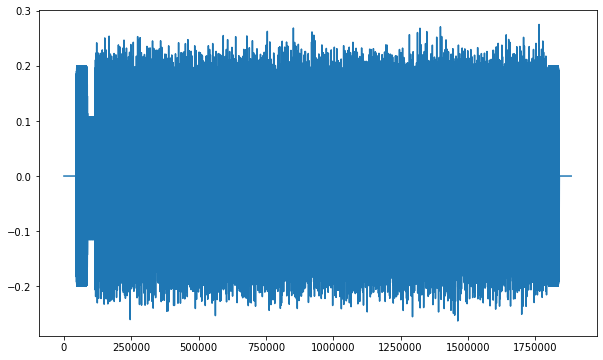

In [10]:
tx_signal, inverse_chirp, repeats, known_frame, carrier_indices = create_tx_waveform('shakespeare.txt')
plt.figure(figsize=(10,6))
plt.plot(tx_signal)


rx_signal = ideal_channel_response(tx_signal)
#rx_signal = real_channel_response(tx_signal)


In [11]:
rx_convolution, peak_start, peak_end = matched_filter(rx_signal, inverse_chirp)

print("Peak start: ", peak_start)
print("Peak end: ", peak_end)

#expected_ch_gap = len(known_frames) + len(data_frames) + len(ch) + 2*gap
#actual_ch_gap = peak_end - peak_start

#sampling_ratio = actual_ch_gap / expected_ch_gap

#print("Actual sampling frequency: ", 44100*sampling_ratio)
#print("Extra sample after every", int((1/(sampling_ratio-1))), "samples")

Peak start:  88199
Peak end:  1839563


In [12]:
def channel_estimate(signal, start, repeats, known_frame, offset=0):
    """Given a signal and the index of the chirp end, calculates the channel frequency
    and impulse response"""
    
    start += N+prefix_no - offset # account for extra filler OFDM frame of length 2304
    length = (N+prefix_no) * repeats
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, length/(N+prefix_no))
    
    average_frame = np.zeros(N+prefix_no)
    for frame in split_frames:     
        average_frame = np.add(average_frame, frame)
    average_frame /= (length/(N+prefix_no))
    
    known_frame = known_frame[prefix_no:]
    rx_known_frame = average_frame[prefix_no:]
    
    known_dft = np.fft.fft(known_frame, N)
    rx_known_dft = np.fft.fft(rx_known_frame, N)
    
    channel_freq_response = np.zeros(N//2, dtype=complex)
    np.divide(rx_known_dft[:N//2], known_dft[:N//2], out=channel_freq_response, where=known_dft[:N//2] != 0) # should catch divide by zero errors
    
    channel_freq_response = np.append(channel_freq_response, np.append(0,np.conj(channel_freq_response)[:0:-1]))
    
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response, split_frames
    
    

In [29]:
offset = 0
freq_response, imp_response, all_frames = channel_estimate(rx_signal, peak_start, repeats, known_frame, offset)

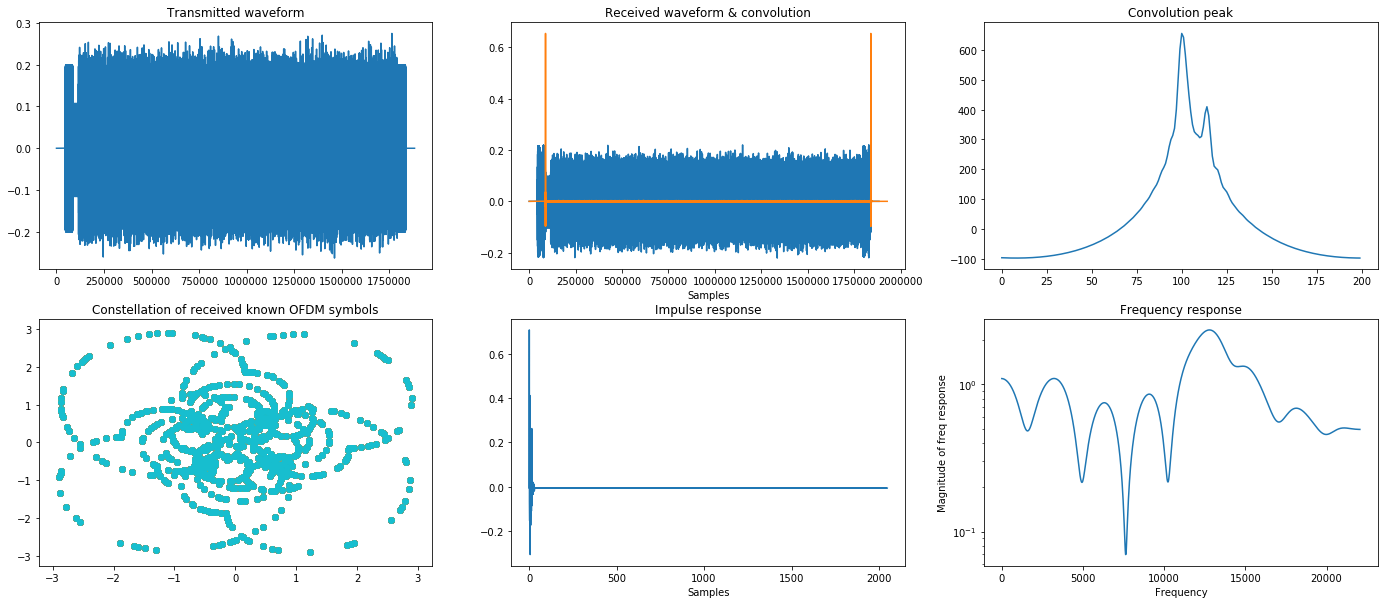

In [30]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(rx_convolution/1000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(rx_convolution[peak_start-100:peak_start+100])

for i in range(len(all_frames)):
    tst_symbols = np.fft.fft(all_frames[i][prefix_no:], N)[1:N//2]
    axs[1][0].scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
axs[1][0].set_title('Constellation of received known OFDM symbols')


axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response[:])
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))

(730, 2304)


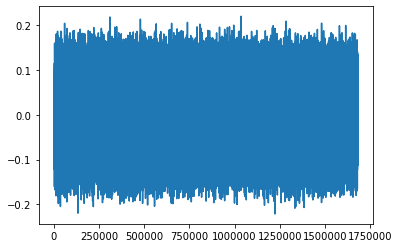

In [31]:
data_begin = peak_start + 11*(N+prefix_no) + offset # as 1 random & 10 known ofdm frames after chirp
data_end = peak_end - len(inverse_chirp) + offset # use end chirp to determine signal length for now, will need a fix later
# potential for data_being -> data_end to not be the correct length

rx_data_full = rx_signal[data_begin:data_end]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))
print(np.shape(rx_data_frames))
plt.plot(rx_signal[data_begin-1000:data_end+1000])

In [32]:
preamble_points = np.arange(0, len(rx_data_frames), 11)
just_data = np.delete(rx_data_frames, preamble_points, axis=0)
print(len(just_data))

663


In [33]:
def correct_phase_decode_data(all_frames, carrier_indices, channel_fft, filename, pilot_value=1+1j):
    
    pilot_indices = carrier_indices[0]
    data_indices = np.array(carrier_indices[1])
    
    pilot_symbols = []
    data_symbols = []
    
    preamble_points = np.arange(0, len(rx_data_frames), 11) # remove preamble frame before each set of 10 data blocks
    data_frames = np.delete(all_frames, preamble_points, axis=0)
    
    bits = ""
    for i in range(len(data_frames)):
        
        frame_no_cp = data_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_demod = pilots / channel_fft[pilot_indices]
        pilots_phase_change = np.angle(pilots_demod / pilot_value) # divide by each known pilot symbol and get phase change
        
        phase_adjustment = np.polyfit(pilot_indices, np.unwrap(pilots_phase_change), 1)[0] # take gradient, intercept should be zero
        
        pilots *=  np.exp(-1j*phase_adjustment*pilot_indices)
        data *=  np.exp(-1j*phase_adjustment*data_indices)

        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
        
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols

In [34]:
data_symbols, pilot_symbols = correct_phase_decode_data(rx_data_frames, carrier_indices, freq_response, 'decoded_shakespeare.txt', 1+1j)

(663, 2304)
bitstr written to  decoded_shakespeare.txt
